# THE CHALLENGE

The problem we will be looking at is an image classification task on X-ray scans of the human body.

In this example, we focus on images of the spine which are frequently used during the planning of surgical procedures. 

An automated analysis of such images is thus an important feature.

The first step in such a process is to detect in which direction the X-ray was taken. Roughly speaking, there are two ways:

1. The X-rays traverse the body from front to back (or back to front). We call such images AP (stands for „anteroposterior”).

2. The X-rays traverse the body from left to right (or right to left). We call such images lateral.




In [104]:
import sys

import os 
from os import makedirs
from os import listdir

import shutil
from shutil import copyfile

from random import seed
from random import random


from matplotlib import pyplot
from matplotlib.image import imread
import matplotlib.pyplot as plt

#from PIL import Image
#from resizeimage import resizeimage
import cv2

from numpy import asarray
from numpy import save
from numpy import load
from numpy.random import seed
seed(42)

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.layers import Dropout
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.models import load_model

from sklearn.metrics import confusion_matrix



# data exploration

- show train and test set size
- plot some images



In [4]:
# define location of dataset
train_folder = '../SnkeOS_MLENgineer_ChallengeData/Train/'
test_folder = '../SnkeOS_MLENgineer_ChallengeData/Test/'

train_image_file = 'train_images.npy'
train_label_file = 'train_labels.npy'

test_image_file = 'test_images.npy'
test_label_file = 'test_labels.npy'

img_size = (256, 256)

lateral_label = 'Lateral'
ap_label = 'AP'


In [5]:
def get_img_files(folder, 
                  lateral_label='Lateral', 
                  ap_label='AP',
                 #images_file,
                 #labels_file,
                 #img_size=(256, 256),
                ):
    lateral_files = []
    ap_files = []
    files = []
    
    #labels = list()
    #images = list()
    for file_name in os.listdir(folder):
        label = ''
        if lateral_label in file_name:
            lateral_files.append(folder + file_name)
            label = 'Lateral'
        if ap_label in file_name:
            ap_files.append(folder + file_name)
            label = 'AP'
            
        #files.append(folder + file_name)
        #labels.append(label)
        # load image
        #image = load_img(folder + file_name, target_size=img_size)
        # convert to numpy array
        #image = img_to_array(image)
        #images.append(image)

    # convert to a numpy arrays
    #images = asarray(images)
    #labels = asarray(labels)
    #print(images.shape, labels.shape)

    # save the images
    #save(images_file, images)
    #save(labels_file, labels)
    
    return lateral_files, ap_files
    
    

In [6]:
train_lateral_files, train_ap_files = get_img_files(folder=train_folder)

print('number of train lateral images', len(train_lateral_files))
print('number of test ap images', len(train_ap_files))


number of train lateral images 83
number of test ap images 107


In [7]:
test_lateral_files, test_ap_files = get_img_files(folder=test_folder)                                                                           

print('number of test lateral images', len(test_lateral_files))
print('number of test ap images', len(test_ap_files))


number of test lateral images 13
number of test ap images 14


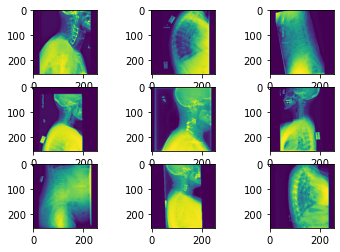

In [8]:
for i in range(9):
    pyplot.subplot(330 + 1 + i)
    filename = train_lateral_files[i]
    image = imread(filename)
    pyplot.imshow(image)

pyplot.show()



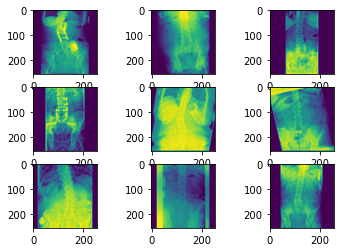

In [9]:
for i in range(9):
    pyplot.subplot(330 + 1 + i)
    filename = train_ap_files[i]
    image = imread(filename)
    pyplot.imshow(image)

pyplot.show()


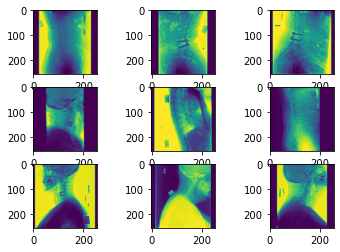

In [10]:
for i in range(9):
    pyplot.subplot(330 + 1 + i)
    filename = test_lateral_files[i]
    image = imread(filename)
    pyplot.imshow(image)

pyplot.show()


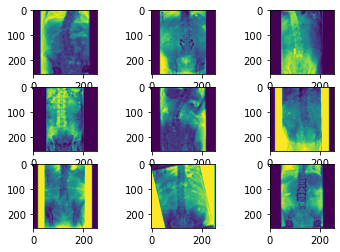

In [11]:
for i in range(9):
    pyplot.subplot(330 + 1 + i)
    filename = test_ap_files[i]
    image = imread(filename)
    pyplot.imshow(image)

pyplot.show()


# Prepare train, validation, and test sets

- randomly select 20% images from the train images as validation set
- save the train, validation, and test images into folders
- due to limited computing resources, images are resized


In [93]:
# create directories
dataset_home = 'lateral_vs_ap/'
subdirs = ['train/', 'test/', 'valid/', 'final_train/']
final_train_dir = dataset_home + subdirs[-1]
resize_img = (128, 128)
#resize_img = None
# define ratio of pictures to use for validation
val_ratio = 0.2
# seed random number generator
seed(42)


for subdir in subdirs:
    # create label subdirectories
    labeldirs = ['lateral/', 'ap/']
    for labldir in labeldirs:
        newdir = dataset_home + subdir + labldir
        if os.path.exists(newdir):
            shutil.rmtree(newdir)
        makedirs(newdir, exist_ok=False)

        
# copy training and testing dataset images into subdirectories
def save_images(src_directory, dataset_home, dst_dir_input, resize_img, val_ratio=0):
    for file in listdir(src_directory):
        src = src_directory + '/' + file
        
        dst_dir = dst_dir_input
        if val_ratio and random() < val_ratio:
            dst_dir = 'valid/'
        
        dst = ''
        if 'Lateral' in file:
            dst = dataset_home + dst_dir + 'lateral/'  + file
            copyfile(src, dst)
        if 'AP' in file:
            dst = dataset_home + dst_dir + 'ap/'  + file
            copyfile(src, dst)
        
        # resize image
        if resize_img:
            src = cv2.imread(dst, cv2.IMREAD_UNCHANGED)
            output = cv2.resize(src, resize_img)
            cv2.imwrite(dst, output) 
    
    
# create train and validation set
save_images(train_folder, dataset_home, 'train/', resize_img, val_ratio)
# create test set
save_images(test_folder, dataset_home, 'test/', resize_img)
# create final train set
save_images(train_folder, dataset_home, 'final_train/', resize_img)


# model creation


## baseline CNN model

- develop a baseline convolutional neural network model based on the VGG models
https://arxiv.org/abs/1409.1556


    - stacking convolutional layers with small 3×3 filters followed by a max pooling layer. 
    - these layers form a block, and these blocks can be repeated where the number of filters in each block is increased with the depth of the network such as 32, 64, 128, 256 for the first four blocks of the model. 
    - padding is used on the convolutional layers to ensure the height and width shapes of the output feature maps matches the inputs.
    - each layer will use the ReLU activation function and the He weight initialization, which are generally best practices.
    - the model will be fit with stochastic gradient descent (SGD).
    - the output layer with 1 node and a sigmoid activation will be used because it is a binary classification problem.
    - the model will be optimized using the binary cross-entropy loss function.
    - the model will be fit 10 epochs
    - the model can be evaluated on the test dataset directly and the classification accuracy reported.



In [76]:
def create_baseline_model(img_shape=(256, 256, 3)):
    """
    Define a baseline model
    """
    model = Sequential()
    model.add(Conv2D(32, (3, 3), 
                     activation='relu', 
                     kernel_initializer='he_uniform', 
                     padding='same', 
                     input_shape=img_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model
 

def plot_learning_curves(history):
    """
    Plot the learing curves
    """
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    pyplot.savefig(filename + '_plot.png')
    pyplot.close()
    image = imread(filename + '_plot.png')
    pyplot.figure(figsize=(10, 15))
    pyplot.imshow(image)

    
def run_test(model,
             img_size=(256, 256),
             epochs=20,
             augment_data=False,
             train_folder='lateral_vs_ap/train/',
             valid_folder='lateral_vs_ap/valid/',
             test_folder='lateral_vs_ap/test/',
            ):
    """
    # run the test harness for evaluating a model
    """
    #model = baseline_model()
    
    # scale the pixel values to the range of 0-1.
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    
    # prepare iterators
    if augment_data:
        train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                           width_shift_range=0.1, 
                                           height_shift_range=0.1, 
                                           horizontal_flip=True,
                                          )
            
        train_it = train_datagen.flow_from_directory(train_folder,
                                                     class_mode='binary', 
                                                     batch_size=64, 
                                                     target_size=img_size,
                                                    )
    else:
        train_it = datagen.flow_from_directory(train_folder,
                                               class_mode='binary', 
                                               batch_size=64, 
                                               target_size=img_size,
                                              )
    
    valid_it = datagen.flow_from_directory(valid_folder,
                                           class_mode='binary', 
                                           batch_size=64, 
                                           target_size=img_size,
                                          )
    
    test_it = datagen.flow_from_directory(test_folder,
                                          class_mode='binary', 
                                          batch_size=64, 
                                          target_size=img_size,
                                         )
    # fit model
    history = model.fit_generator(train_it, 
                                  steps_per_epoch=len(train_it),
                                  validation_data=valid_it, 
                                  validation_steps=len(valid_it), 
                                  epochs=epochs, 
                                  verbose=0,
                                 )
    # evaluate model
    _, acc = model.evaluate_generator(train_it, steps=len(train_it), verbose=0)
    print('train accuracy %.3f' % (acc * 100.0))
    _, acc = model.evaluate_generator(valid_it, steps=len(valid_it), verbose=0)
    print('validation accuracy %.3f' % (acc * 100.0))
    _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
    print('test accuracy %.3f' % (acc * 100.0))
    # learning curves
    plot_learning_curves(history)






Found 153 images belonging to 2 classes.
Found 37 images belonging to 2 classes.
Found 27 images belonging to 2 classes.
train accuracy 90.850
validation accuracy 67.568
test accuracy 48.148


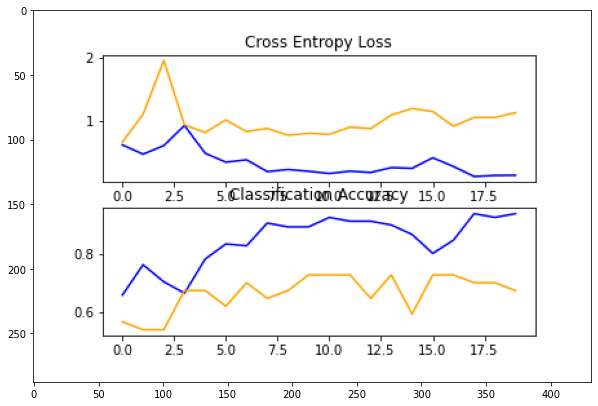

In [54]:
baseline_model = create_baseline_model(img_shape=(128, 128, 3))
run_test(model=baseline_model, img_size=(128, 128), epochs=20)


## VGG model

- two-block vgg model
- three-block vgg model


In [58]:
def create_two_block_vgg_model(img_shape=(256, 256, 3)):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=img_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model



Found 153 images belonging to 2 classes.
Found 37 images belonging to 2 classes.
Found 27 images belonging to 2 classes.
train accuracy 92.157
validation accuracy 70.270
test accuracy 59.259


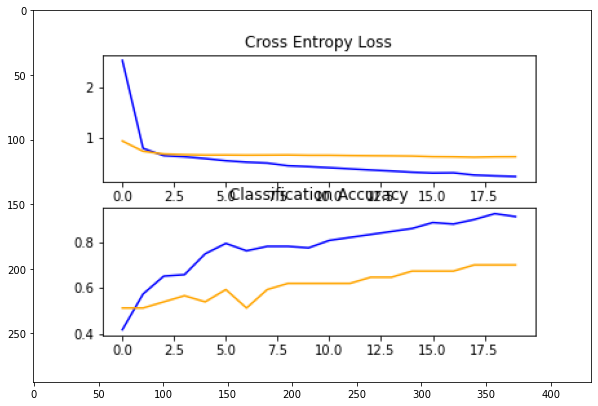

In [59]:
two_block_vgg_model = create_two_block_vgg_model(img_shape=(128, 128, 3))
run_test(model=two_block_vgg_model, img_size=(128, 128), epochs=20)



In [60]:
# define cnn model
def create_three_block_vgg_model(img_shape=(256, 256, 3)):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=img_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


Found 153 images belonging to 2 classes.
Found 37 images belonging to 2 classes.
Found 27 images belonging to 2 classes.
train accuracy 96.078
validation accuracy 72.973
test accuracy 62.963


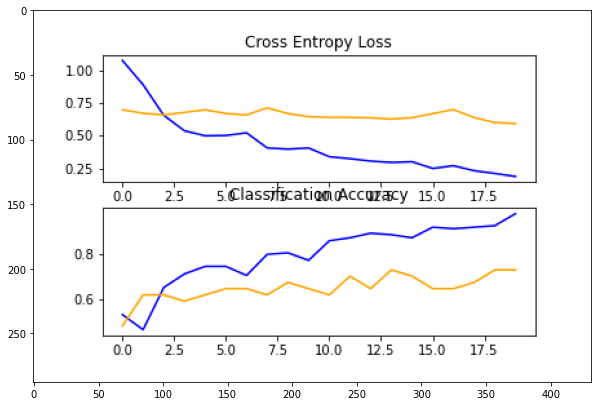

In [61]:
three_block_vgg_model = create_three_block_vgg_model(img_shape=(128, 128, 3))
run_test(model=three_block_vgg_model, img_size=(128, 128), epochs=20)



## model improvement



### dropout regularization

Dropout works by probabilistically removing inputs to a layer, 
which may be input variables in the data sample or activations from a previous layer. 

It has the effect of simulating a large number of networks with very different network structures and 
makes nodes in the network generally more robust to the inputs.


https://machinelearningmastery.com/how-to-reduce-overfitting-with-dropout-regularization-in-keras/


In [73]:
def create_vgg_model(img_shape=(256, 256, 3)):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=img_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    #model.add(Dropout(0.5))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


Found 153 images belonging to 2 classes.
Found 37 images belonging to 2 classes.
Found 27 images belonging to 2 classes.
train accuracy 86.275
validation accuracy 64.865
test accuracy 62.963


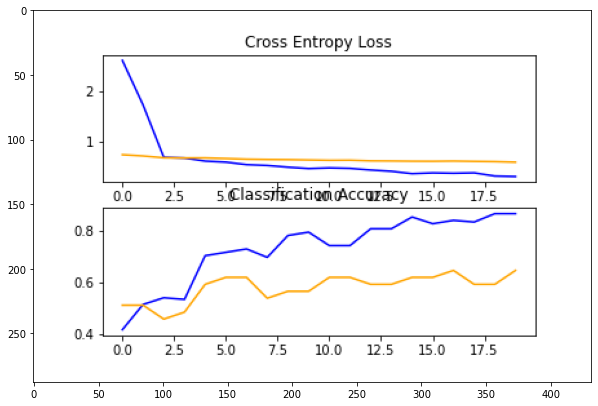

In [74]:
vgg_model = create_vgg_model(img_shape=(128, 128, 3))
run_test(model=vgg_model, img_size=(128, 128), epochs=20)


### data augmentation


Found 153 images belonging to 2 classes.
Found 37 images belonging to 2 classes.
Found 27 images belonging to 2 classes.
train accuracy 68.627
validation accuracy 75.676
test accuracy 62.963


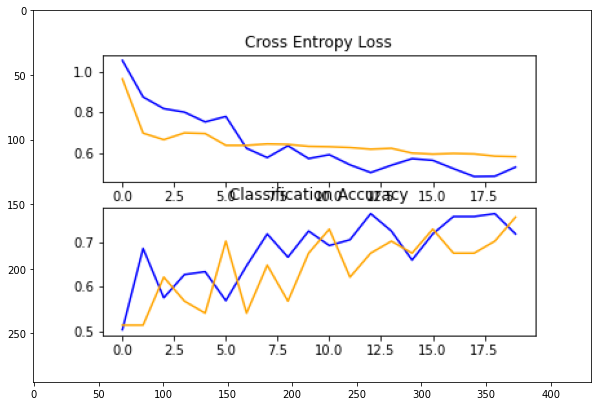

In [80]:
vgg_model = create_vgg_model(img_shape=(128, 128, 3))
run_test(model=vgg_model, img_size=(128, 128), epochs=20, augment_data=True)


## transfer learning


In [87]:

def create_vgg16_model(img_shape=(256, 256, 3)):
    model = VGG16(include_top=False, input_shape=img_shape)
    for layer in model.layers:
        layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(1, activation='sigmoid')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


Found 153 images belonging to 2 classes.
Found 37 images belonging to 2 classes.
Found 27 images belonging to 2 classes.
train accuracy 95.425
validation accuracy 91.892
test accuracy 88.889


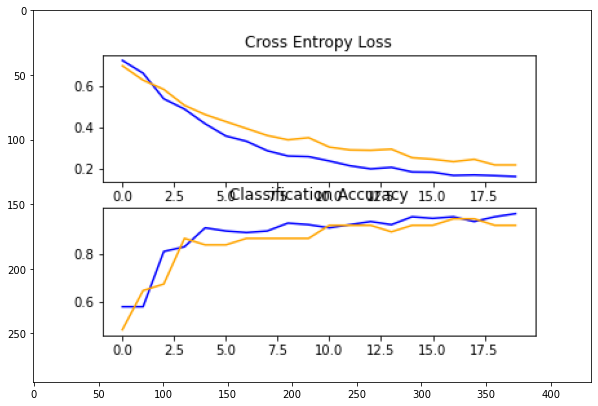

In [88]:
vgg16_model = create_vgg16_model(img_shape=(128, 128, 3))
run_test(model=vgg16_model, img_size=(128, 128), epochs=20, augment_data=True)


# result evaluation


## train and save final model


In [94]:
def train_vgg16_final(img_shape=(128, 128, 3), epochs=20):
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       width_shift_range=0.1, 
                                       height_shift_range=0.1, 
                                       horizontal_flip=True,
                                      )

    train_it = train_datagen.flow_from_directory(final_train_dir,
                                                 class_mode='binary', 
                                                 batch_size=64, 
                                                 target_size=(img_shape[0], img_shape[1]),
                                                )


    vgg16_model = create_vgg16_model(img_shape=img_shape)
    vgg16_model.fit_generator(train_it, steps_per_epoch=len(train_it), epochs=epochs, verbose=0)

    vgg16_model.save('vgg16_model.h5')
    print('the final model is saved in vgg16_model.h5')
    
    return



In [95]:
train_vgg16_final(img_shape=(128, 128, 3), epochs=20)


Found 190 images belonging to 2 classes.
the final model is saved in vgg16_model.h5


## make prediction 

In [98]:
vgg16_model = load_model('vgg16_model.h5')

test_datagen = ImageDataGenerator(rescale=1/255.)

test_generator = test_datagen.flow_from_directory('lateral_vs_ap/test/',
                                                  class_mode='binary', 
                                                  batch_size=64, 
                                                  target_size=(128, 128),
                                                 )

preds = vgg16_model.predict_generator(test_generator)


Found 27 images belonging to 2 classes.
Instructions for updating:
Please use Model.predict, which supports generators.


In [109]:
test_images, test_labels = test_generator.next()

print(len(test_labels))

#for i in range(0, 10):
#    image = x[i]
#    label = y[i]
#    print (label)
#    plt.imshow(image)
#    plt.show()
    

27


In [99]:
preds

array([[0.04837933],
       [0.11820662],
       [0.08494306],
       [0.9104886 ],
       [0.0135369 ],
       [0.00745976],
       [0.29743305],
       [0.76789296],
       [0.00684306],
       [0.16428035],
       [0.01405716],
       [0.00557899],
       [0.04202503],
       [0.04908231],
       [0.9631967 ],
       [0.4144187 ],
       [0.0542084 ],
       [0.6764027 ],
       [0.7468864 ],
       [0.2480556 ],
       [0.8517343 ],
       [0.56273127],
       [0.02242258],
       [0.4110366 ],
       [0.98213834],
       [0.5073182 ],
       [0.01200029]], dtype=float32)

In [111]:
pred_labels = preds > 0.5

confusion_matrix(test_labels, pred_labels)


array([[10,  4],
       [ 8,  5]])

# troubleshooting


## plot correctly classified images


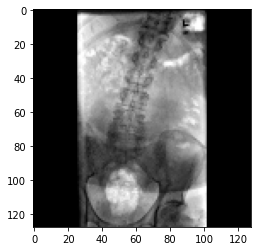

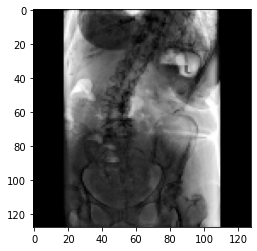

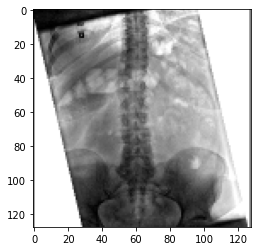

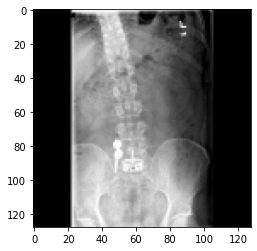

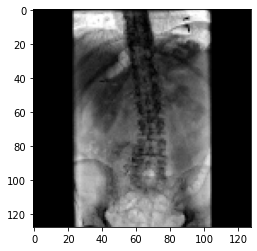

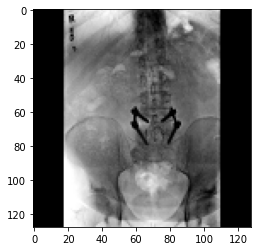

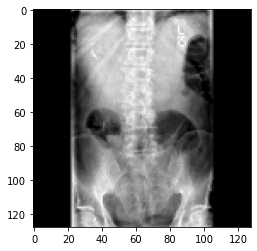

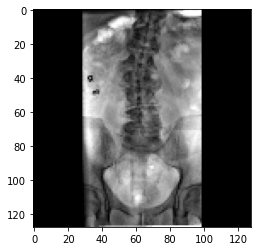

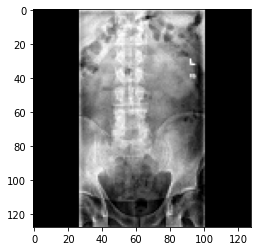

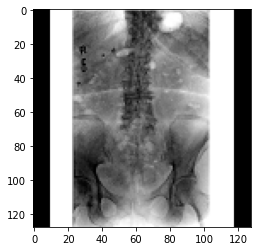

In [114]:
for i in range(len(test_labels)):
    if test_labels[i] == 0 and test_labels[i] == pred_labels[i]:
        image = test_images[i]
        plt.imshow(image)
        plt.show()

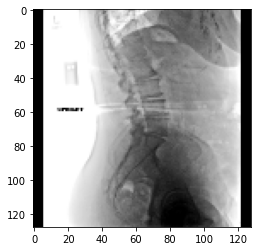

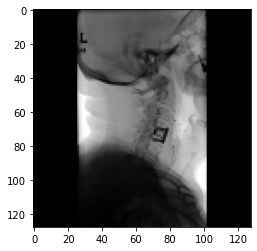

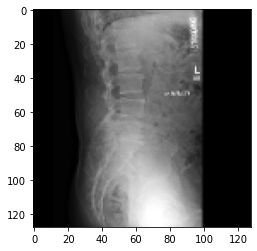

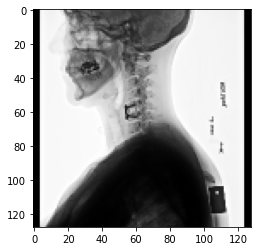

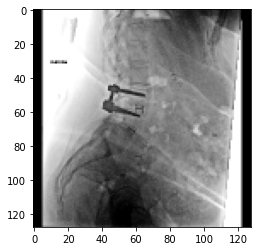

In [115]:
for i in range(len(test_labels)):
    if test_labels[i] == 1 and test_labels[i] == pred_labels[i]:
        image = test_images[i]
        plt.imshow(image)
        plt.show()
        

## plot misclassified images


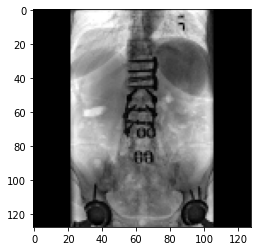

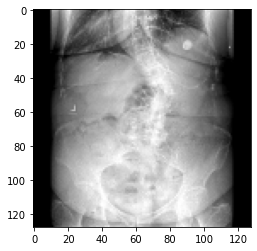

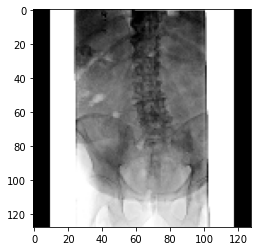

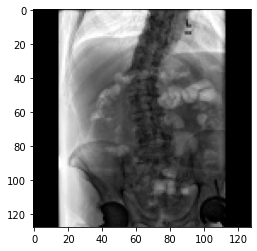

In [112]:
for i in range(len(test_labels)):
    if test_labels[i] == 0 and test_labels[i] != pred_labels[i]:
        image = test_images[i]
        plt.imshow(image)
        plt.show()
        
    

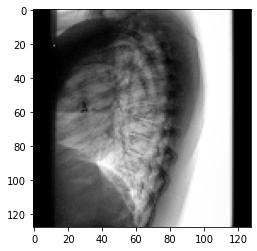

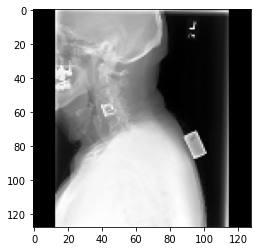

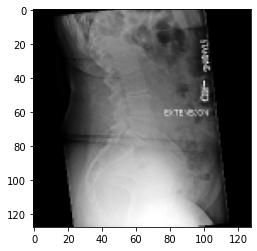

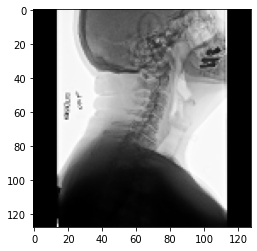

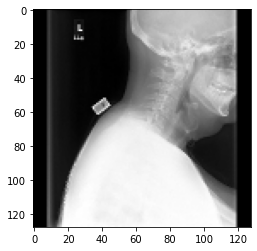

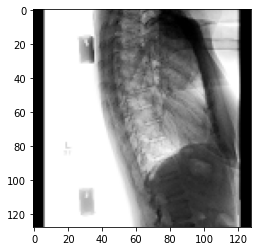

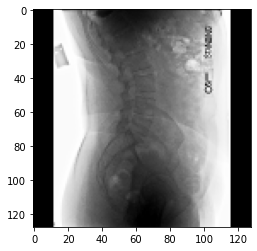

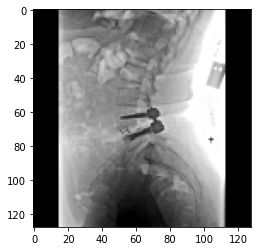

In [113]:
for i in range(len(test_labels)):
    if test_labels[i] == 1 and test_labels[i] != pred_labels[i]:
        image = test_images[i]
        plt.imshow(image)
        plt.show()
        

# Reference

* Collection! Deep learning must read 10 classic algorithm paper summary!

https://developpaper.com/collection-deep-learning-must-read-10-classic-algorithm-paper-summary/


* How to Classify Photos of Dogs and Cats (with 97% accuracy)

https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/



* Convolutional Neural Networks, Coursera, deeplearning.ai

https://www.coursera.org/learn/convolutional-neural-networks


* Deep Learning vs. Traditional Computer Vision

https://arxiv.org/pdf/1910.13796.pdf


* Image Classification

https://paperswithcode.com/task/image-classification


* Dog vs Cat, kaggle competition

https://www.kaggle.com/c/dogs-vs-cats


